In [3]:
from QAOAUtils import * 
from LieUtils import *

This notebook is meant to parallelize the variance estimation, specificlly for the beta variance, the proccess is similar to the last example.
All of the following is a single iteration of the run. We start by generating a 8-vertex (equivalently 8 qubit) adjacency matrix.

In [2]:
n = 8
A= rand_adj(n)

In [3]:
Y = GW(A)  ###calculate the full GW embedding
_,GW2_angles,_ = GW2(A,GW_Y=Y) ###project to 2d angles using precalculated GW embedding 
_,GW3_angles,_ = GW3(A,GW_Y=Y) ###project to 2d angles using precalculated GW embedding 

In [4]:
###Get circuit information for each warmstart. Circuit information consists of the initial state + the mixer operators for each qubit
GW2_circ_data = Q2_data(GW2_angles,rotation = 0)
GW3_circ_data = Q3_data(GW3_angles,rotation = 0)

In [5]:
precomp  = pre_compute(A) ###compute the Hamiltonian information for the cost layers (shared for all circuits)

Variance Depth is used as a wrapper in order to run a variance function across various depths, in this case from 10 to 200.

In [6]:
#max_p temporarilty set to 40 for speed of example (normally 210), shots normally 1000
def variance_depth(variance_sample, precomp, initial_p=10, max_p=40, step_size=10,mixer_ops=None, init=None, shots=1000):
    vars = []
    for i in tqdm(range(initial_p, max_p, step_size), "Individual Progress"):
        p = i
        var = variance_sample(precomp,p,mixer_ops,init,shots)
        vars.append(var)
    return vars

This is the originl variance sample without parallel proccessing

In [7]:
def variance_sample(f,n_params,shots=1000):
    data = []
    for i in tqdm(range(shots)):
        data.append((f(np.random.random(n_params) * 2 * np.pi)))
    return np.mean(np.var(data,axis=0))

The joblib library is used for parallel processing here to break the loop into separate tasks and run them across multiple CPU cores. 

In [8]:
def variance_sample(f, n_params, shots=1000, n_jobs=-1, tqdm_enabled=False):
    param_list = [np.random.random(n_params) * 2 * np.pi for _ in range(shots)]
    
    if tqdm_enabled:
        with tqdm_joblib(total=shots):
            results = Parallel(n_jobs=n_jobs)(
                delayed(f)(params) for params in param_list
            )
    else:
        results = Parallel(n_jobs=n_jobs)(
            delayed(f)(params) for params in param_list
        )
    
    return np.mean(np.var(results, axis=0))

This new Variance Sample is run with the same beta variance function

In [9]:
def beta_variance_sample(precomp,p,mixer_ops=None,init=None,shots=1000):
    f = lambda params : beta_QAOA_state_derivative(p//2,precomp,params,mixer_ops=mixer_ops,init=init)
    psi = lambda params: QAOA_eval(precomp,params,mixer_ops=mixer_ops,init=init)
    grad = lambda params: 2 * np.sum(f(params).conjugate() * precomp * psi(params)).real
    return variance_sample(grad, 2*p,shots=shots)

The various Beta Variance functions are compiled in this function, this function preforms a single run of the various betas. We also collect the matrix and GW2/GW3 angles. 

In [10]:
def all_beta_variance_run(precomp, GW2_circ_data, GW3_circ_data, A, GW2_angles, GW3_angles):
    pickle_file = 'beta_variance_runs(test).pkl' #Test pkl file
    
    if os.path.exists(pickle_file):
        with open(pickle_file, 'rb') as f:
            all_runs = pickle.load(f)
    else:
        all_runs = []

    #Shots set to 1 simply for the speed of example
    beta_vars_default = variance_depth(beta_variance_sample, precomp, shots=1)
    beta_vars_GW2 = variance_depth(beta_variance_sample, precomp, mixer_ops=GW2_circ_data[1], init=GW2_circ_data[0], shots=1)
    beta_vars_GW3 = variance_depth(beta_variance_sample, precomp, mixer_ops=GW3_circ_data[1], init=GW3_circ_data[0], shots=1)
    
    all_runs.append({
        'beta_vars_default': beta_vars_default,
        'beta_vars_GW2': beta_vars_GW2,
        'beta_vars_GW3': beta_vars_GW3,
        "A": A,
        "GW2_angles" : GW2_angles,
        "GW3_angles": GW3_angles
    })
    
    with open(pickle_file, 'wb') as f:
        pickle.dump(all_runs, f)

We then put the previous steps into a loop.

In [11]:
def beta_variance_run_loop(iterations=10):
    for _ in tqdm(range(iterations), "Overall Progress"):
        n = 8
        A= rand_adj(n)
        
        Y = GW(A)  ###calculate the full GW embedding
        _,GW2_angles,_ = GW2(A,GW_Y=Y) ###project to 2d angles using precalculated GW embedding 
        _,GW3_angles,_ = GW3(A,GW_Y=Y) ###project to 2d angles using precalculated GW embedding 
        
        ###Get circuit information for each warmstart. Circuit information consists of the initial state + the mixer operators for each qubit
        GW2_circ_data = Q2_data(GW2_angles,rotation = 0)
        GW3_circ_data = Q3_data(GW3_angles,rotation = 0)
    
        precomp  = pre_compute(A) ###compute the Hamiltonian information for the cost layers (shared for all circuits)
    
        all_beta_variance_run(precomp, GW2_circ_data, GW3_circ_data, A, GW2_angles, GW3_angles)

In [12]:
beta_variance_run_loop(iterations=1)

Overall Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Individual Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Individual Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Individual Progress:   0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
#This data is very bad due to the lack of shots
with open('beta_variance_runs(test).pkl', 'rb') as f:
    all_runs = pickle.load(f)

Real Data Plots

In [4]:
with open('beta_variance_runs.pkl', 'rb') as f:
    all_runs = pickle.load(f)

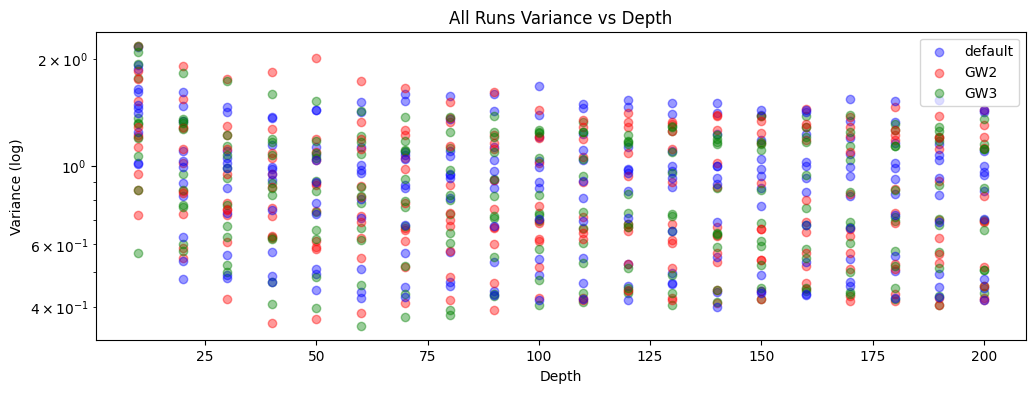

In [15]:
all_variance_plot_together("", all_runs, initial_p=10, max_p=210, step_size=10)

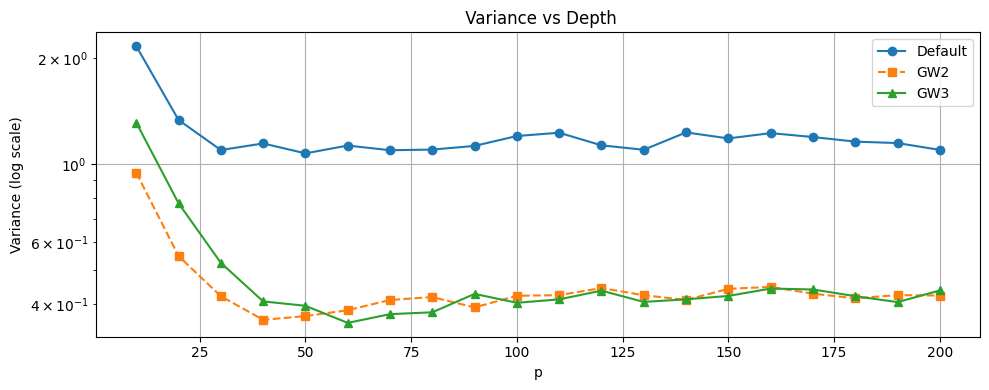

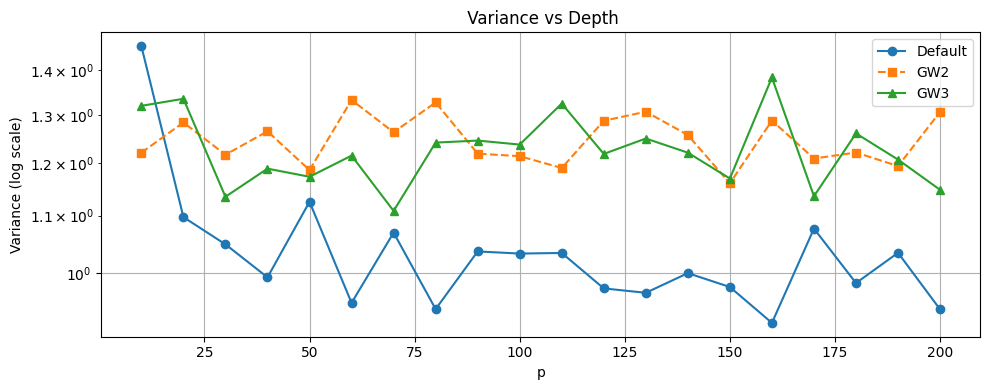

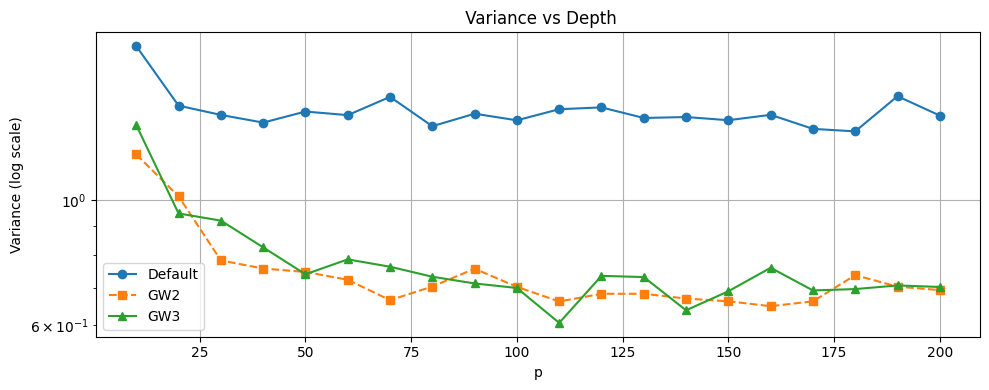

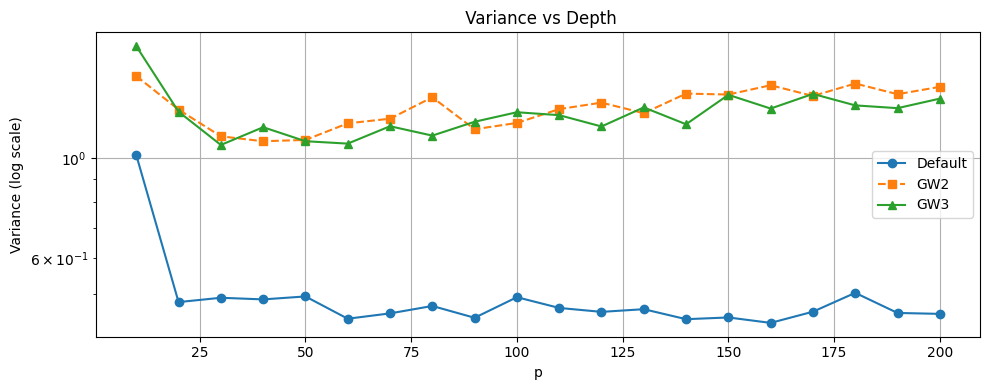

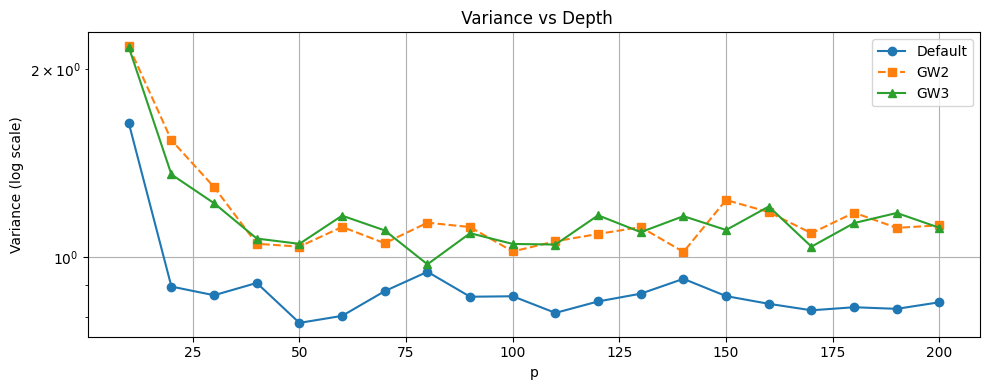

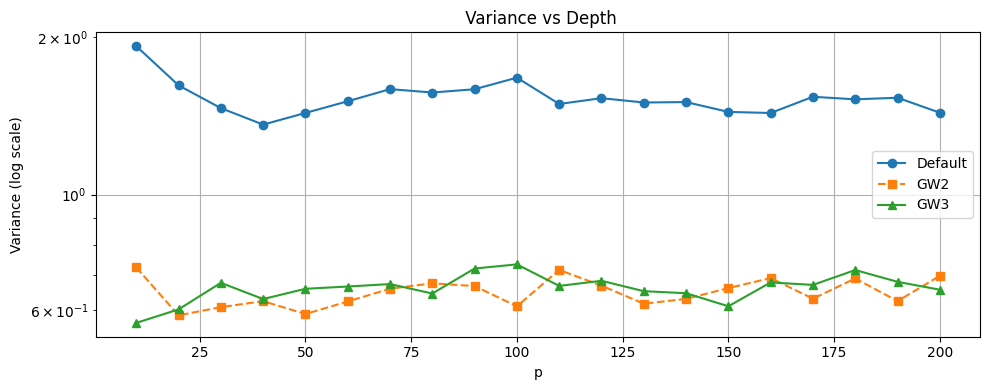

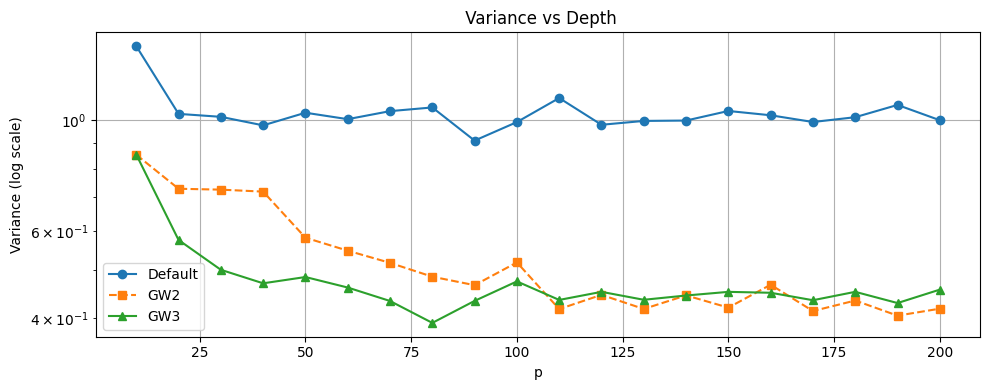

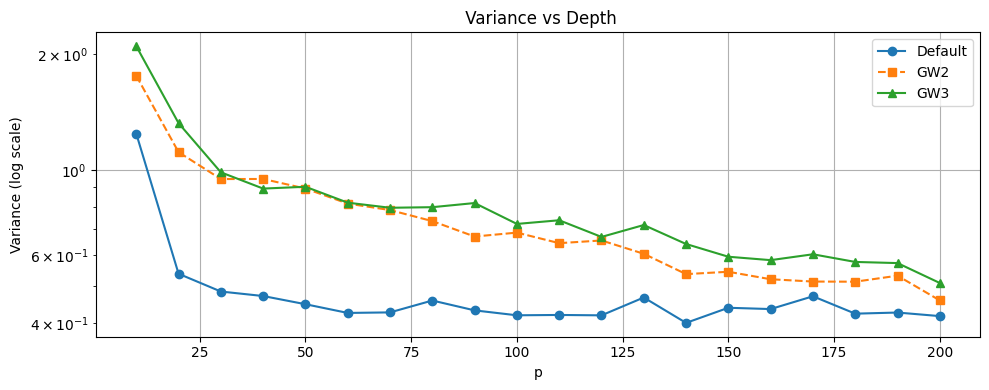

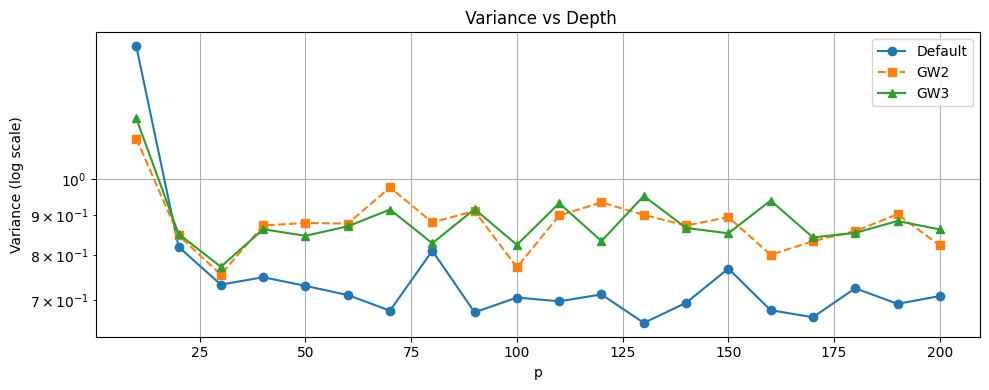

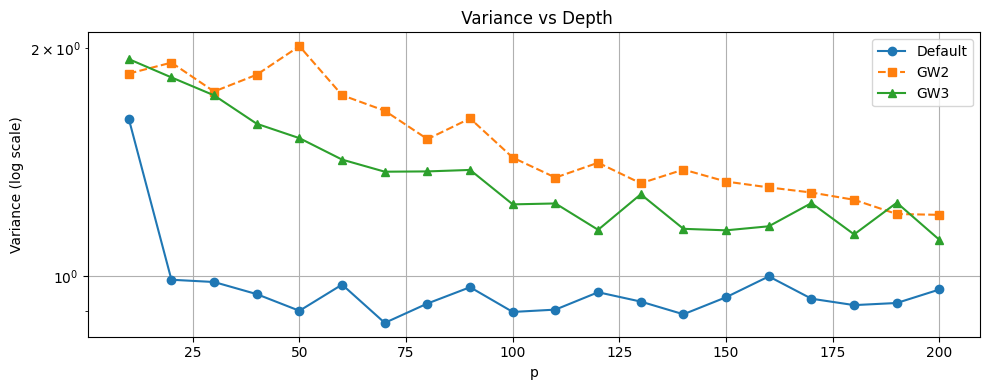

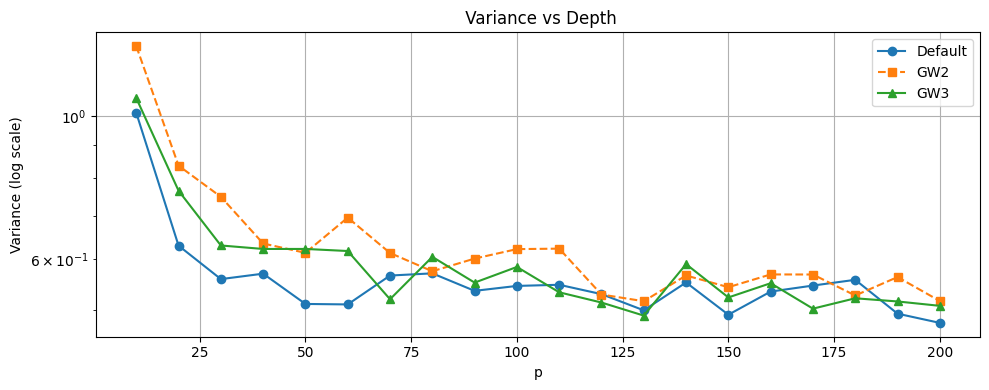

In [16]:
all_variance_plot_separate("", all_runs, initial_p=10, max_p=210, step_size=10)